In [1]:
# create fake data to train on
import gandy.quality_est.datagen
import deepchem.data
data, noise = gandy.quality_est.datagen.generate_analytical_data(False)
dataset = deepchem.data.NumpyDataset.from_dataframe(data, X=['X1', 'X2'], y='Y')

In [2]:
data

,X1,X2,Y
0,5.261854,2.959749,13.432094
1,2.494899,7.603624,12.932735
2,9.118025,6.583945,24.265294
3,4.077810,3.125507,10.820710
4,4.465024,6.084312,14.907811
...,...,...,...
9995,0.311757,7.280841,7.908016
9996,9.170480,4.991424,21.829789
9997,0.766037,7.541754,9.239065
9998,8.760265,2.627589,21.638335


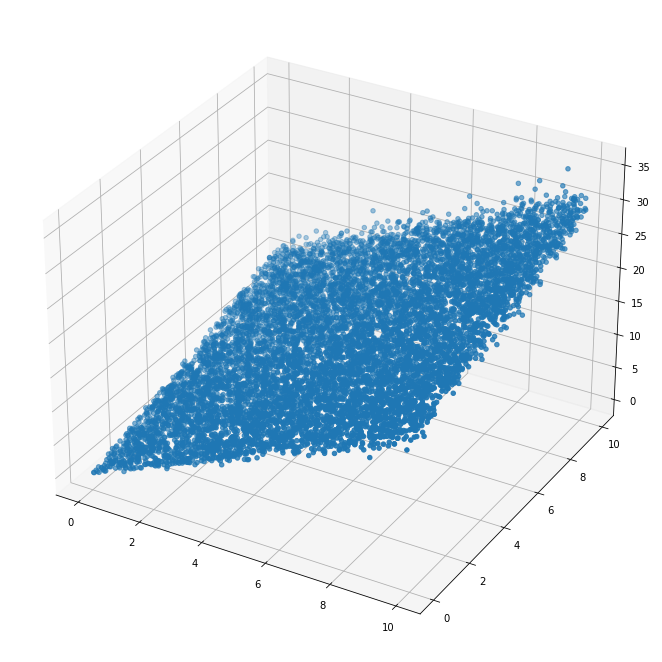

In [3]:
# look at the data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(*list(data.values.T))

## The data gets noisier as X1, X2 increase, hopefully we can capture that noise

In [4]:
import gandy.models.gans
import tensorflow.keras as ks

In [5]:
leaky_relu = ks.layers.LeakyReLU(alpha=0.2)

In [29]:
model = gandy.models.gans.GAN(
    (2,), (1,), noise_shape=(2,), conditional=True,
    generator_layer_dimensions=[12, 6, 2],
    generator_activation=leaky_relu,
    generator_dropout=0.5,
    discriminator_layer_dimensions=[12, 6, 2],
    discriminator_activation=leaky_relu,
    discriminator_dropout=0.5
)

In [30]:
model.train(dataset.X, dataset.y, batches=200000, checkpoint_interval=100)

Step 100: 	Avg gen loss 0.8750205928087235, 	Avg discrim loss 1.5408850347995757
Step 200: 	Avg gen loss 0.710909777879715, 	Avg discrim loss 1.4305901300907136
Step 300: 	Avg gen loss 0.6931840240955353, 	Avg discrim loss 1.398173645734787
Step 400: 	Avg gen loss 0.6940516501665115, 	Avg discrim loss 1.3918615877628326
Step 500: 	Avg gen loss 0.6949652189016342, 	Avg discrim loss 1.3907360911369324
Step 600: 	Avg gen loss 0.6971759462356567, 	Avg discrim loss 1.385104180574417
Step 700: 	Avg gen loss 0.6998684400320053, 	Avg discrim loss 1.3860016775131225
Step 800: 	Avg gen loss 0.7010742074251175, 	Avg discrim loss 1.3815916872024536
Step 900: 	Avg gen loss 0.7033714389801026, 	Avg discrim loss 1.3828498065471648
Step 1000: 	Avg gen loss 0.704104809165001, 	Avg discrim loss 1.3786992931365967
Step 1100: 	Avg gen loss 0.7054758167266846, 	Avg discrim loss 1.3777397537231446
Step 1200: 	Avg gen loss 0.7077154713869095, 	Avg discrim loss 1.3761627912521361
Step 1300: 	Avg gen loss 0.71

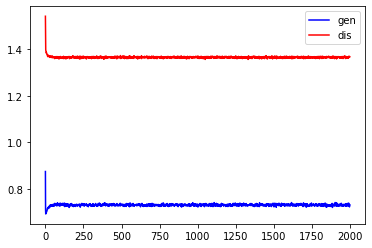

In [31]:
fig, ax = plt.subplots()

ax.plot(list(model.sessions.values())[0][0], label='gen', c='b')
ax.plot(list(model.sessions.values())[0][1], label='dis', c='r')
plt.legend()

In [36]:
pred, unc = model.predict(dataset.X, num_predictions=1000)

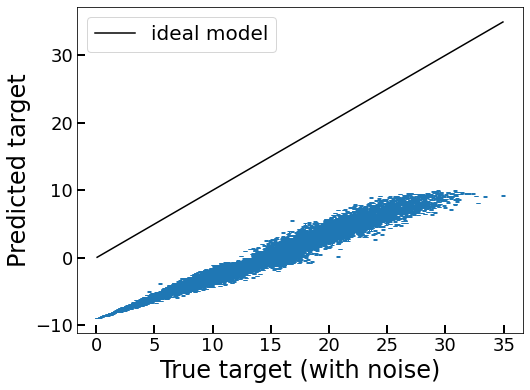

In [37]:
fig, ax = plt.subplots(figsize=(8,6))

# set ax limits
minv, maxv = dataset.y.min(), dataset.y.max()
# ax.set_ylim([minv, maxv])
# ax.set_xlim([minv, maxv])

# plot predictions of models
ax.errorbar(dataset.y, pred, yerr=unc.reshape(-1), ls='none', linewidth=1,
            capsize=2)
# perfect result
ax.plot([minv, maxv], [minv, maxv], c='k', label='ideal model')

# labels
ax.set_ylabel('Predicted target', size=24)
ax.set_xlabel('True target (with noise)', size=24)

# format ticks
plt.setp(ax.get_xticklabels(), fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.tick_params(direction='in', width=2, length=8)

plt.legend(fontsize=20)
plt.show()

## See if we get the expected distro of unc

In [38]:
import numpy as np

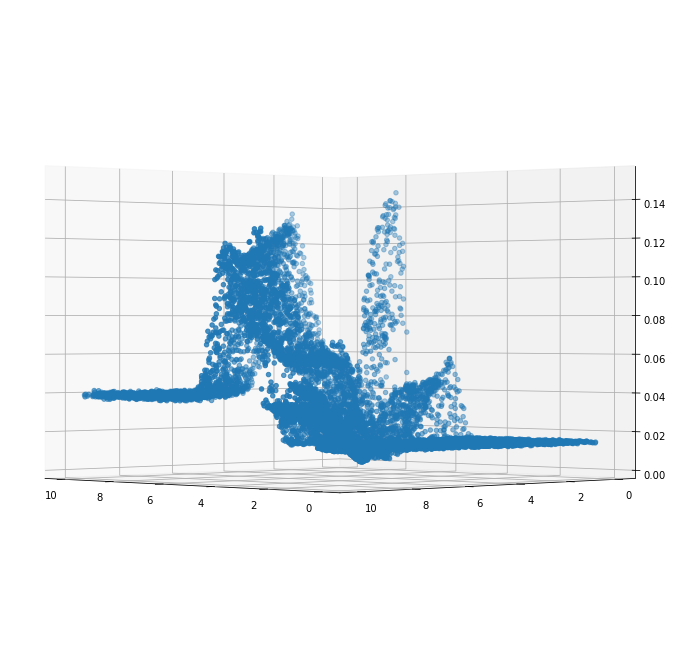

In [43]:
fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(*dataset.X.T, unc.flatten())
ax.view_init(elev=0, azim=135)